In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples

In [13]:
# Load the datasets
orders = pd.read_csv('orders.csv')
order_products = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

# Merge datasets to get a comprehensive view
order_products = order_products.merge(products, on='product_id', how='left')
order_products = order_products.merge(aisles, on='aisle_id', how='left')
order_products = order_products.merge(departments, on='department_id', how='left')
orders = orders.merge(order_products, on='order_id', how='left')
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,soy lactosefree,dairy eggs
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,popcorn jerky,snacks
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,popcorn jerky,snacks
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,paper goods,household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32640693,2977660,206209,prior,13,1,12,7.0,38730.0,6.0,0.0,Brownie Crunch High Protein Bar,3.0,19.0,energy granola bars,snacks
32640694,2977660,206209,prior,13,1,12,7.0,31477.0,7.0,0.0,High Protein Bar Chunky Peanut Butter,3.0,19.0,energy granola bars,snacks
32640695,2977660,206209,prior,13,1,12,7.0,6567.0,8.0,0.0,Chocolate Peanut Butter Protein Bar,3.0,19.0,energy granola bars,snacks
32640696,2977660,206209,prior,13,1,12,7.0,22920.0,9.0,0.0,Roasted & Salted Shelled Pistachios,117.0,19.0,nuts seeds dried fruit,snacks


In [3]:
# Feature engineering
user_order_count = orders.groupby('user_id')['order_id'].nunique().reset_index()
user_order_count.columns = ['user_id', 'total_orders']
user_order_count

,user_id,total_orders
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5
...,...,...
206204,206205,4
206205,206206,68
206206,206207,17
206207,206208,50


In [4]:
avg_days_between_orders = orders.groupby('user_id')['days_since_prior_order'].mean().reset_index()
avg_days_between_orders.columns = ['user_id', 'avg_days_between_orders']
avg_days_between_orders

,user_id,avg_days_between_orders
0,1,20.145455
1,2,16.043716
2,3,11.481013
3,4,16.333333
4,5,14.185185
...,...,...
206204,206205,20.000000
206205,206206,4.028369
206206,206207,14.875000
206207,206208,7.436937


In [5]:
avg_products_per_order = orders.groupby('user_id')['product_id'].count() / orders.groupby('user_id')['order_id'].nunique()
avg_products_per_order = avg_products_per_order.reset_index()
avg_products_per_order.columns = ['user_id', 'avg_products_per_order']
avg_products_per_order

,user_id,avg_products_per_order
0,1,5.363636
1,2,13.000000
2,3,6.769231
3,4,3.000000
4,5,7.400000
...,...,...
206204,206205,8.000000
206205,206206,4.191176
206206,206207,13.117647
206207,206208,13.540000


In [6]:
reorder_ratio = orders.groupby('user_id')['reordered'].mean().reset_index()
reorder_ratio.columns = ['user_id', 'reorder_ratio']
reorder_ratio

,user_id,reorder_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378
...,...,...
206204,206205,0.250000
206205,206206,0.473684
206206,206207,0.587444
206207,206208,0.707533


In [7]:
features = user_order_count.merge(avg_days_between_orders, on='user_id')
features = features.merge(avg_products_per_order, on='user_id')
features = features.merge(reorder_ratio, on='user_id')
features

,user_id,total_orders,avg_days_between_orders,avg_products_per_order,reorder_ratio
0,1,11,20.145455,5.363636,0.694915
1,2,15,16.043716,13.000000,0.476923
2,3,13,11.481013,6.769231,0.625000
3,4,6,16.333333,3.000000,0.055556
4,5,5,14.185185,7.400000,0.378378
...,...,...,...,...,...
206204,206205,4,20.000000,8.000000,0.250000
206205,206206,68,4.028369,4.191176,0.473684
206206,206207,17,14.875000,13.117647,0.587444
206207,206208,50,7.436937,13.540000,0.707533


In [8]:
# Drop the 'user_id' column for clustering
X = features.drop('user_id', axis=1)
X

,total_orders,avg_days_between_orders,avg_products_per_order,reorder_ratio
0,11,20.145455,5.363636,0.694915
1,15,16.043716,13.000000,0.476923
2,13,11.481013,6.769231,0.625000
3,6,16.333333,3.000000,0.055556
4,5,14.185185,7.400000,0.378378
...,...,...,...,...
206204,4,20.000000,8.000000,0.250000
206205,68,4.028369,4.191176,0.473684
206206,17,14.875000,13.117647,0.587444
206207,50,7.436937,13.540000,0.707533


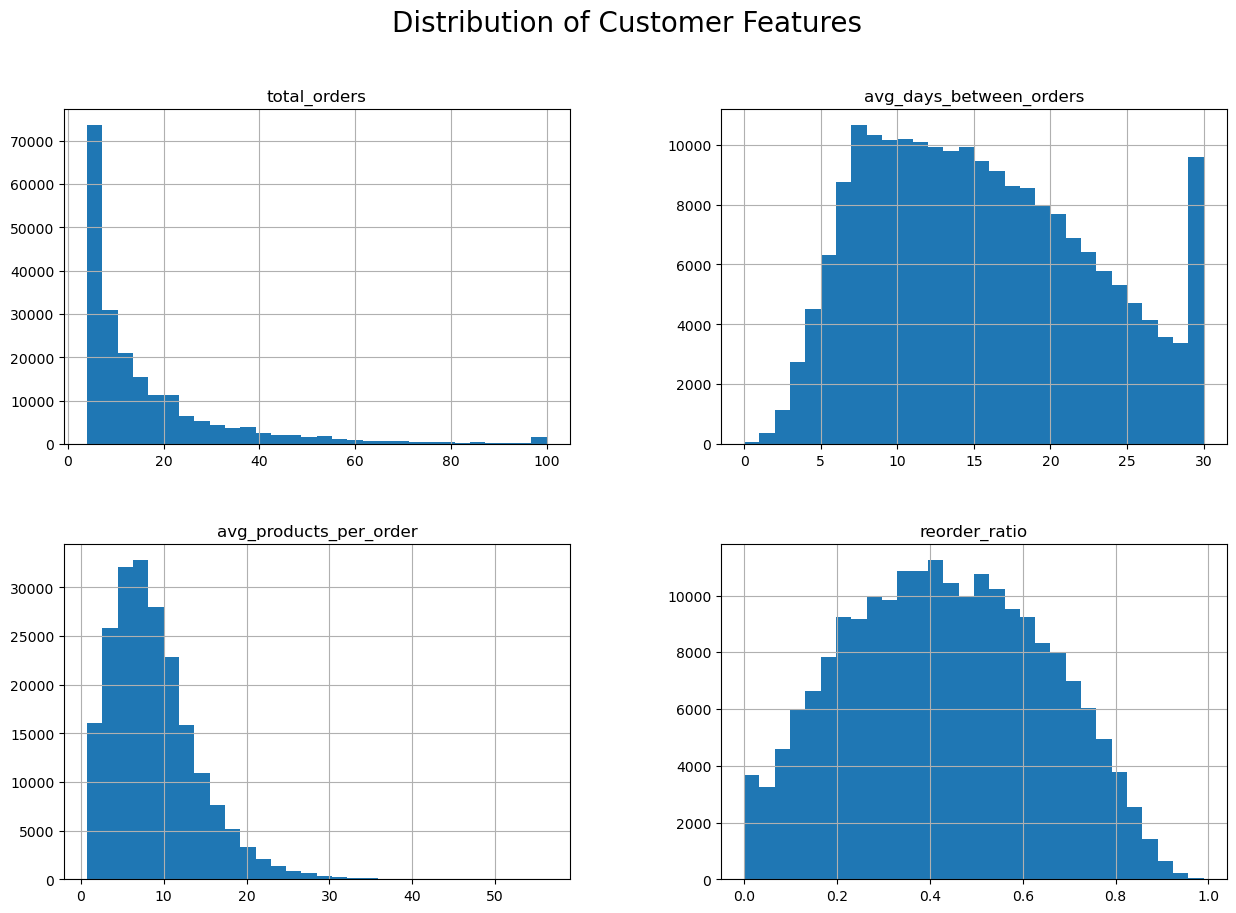

In [9]:
# Histograms
X.hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution of Customer Features', fontsize=20)
plt.show()

In [10]:
# Standardization (Normalization)
def standard_scaler(data):
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    scaled_data = (data - mean) / std_dev
    return scaled_data, mean, std_dev

customer_features_scaled, mean, std_dev = standard_scaler(X.values)

customer_features_scaled 

array([[-0.33566236,  0.64991714, -0.66188574,  1.23815226],
       [-0.0954904 ,  0.07421751,  0.78802381,  0.21058293],
       [-0.21557638, -0.56618079, -0.39500678,  0.90858644],
       ...,
       [ 0.02459559, -0.08981762,  0.81036135,  0.73155509],
       [ 2.00601431, -1.13378713,  0.89055312,  1.29763077],
       [-0.15553339,  0.67988572,  0.06923361,  0.19146918]])

In [11]:
# Elbow Method to determine optimal number of clusters
def calculate_inertia(data, k):
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    clusters = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
    inertia = np.sum(np.min(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1))
    return inertia

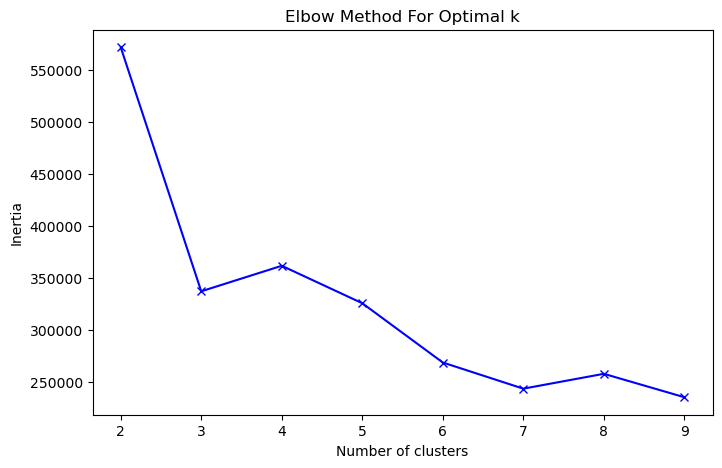

In [12]:
inertia = []
K = range(2, 10)
for k in K:
    inertia.append(calculate_inertia(customer_features_scaled, k))

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [13]:
def kmeans_clustering(data, k, max_iter=300):
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    for _ in range(max_iter):
        clusters = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
        new_centroids = np.array([data[clusters == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return clusters

In [14]:
k_optimal = 3
clusters_3 = kmeans_clustering(customer_features_scaled, k_optimal)

# Add cluster labels to the customer features
X_3 = X
X_3['cluster_3'] = clusters_3
X_3

,total_orders,avg_days_between_orders,avg_products_per_order,reorder_ratio,cluster_3
0,11,20.145455,5.363636,0.694915,2
1,15,16.043716,13.000000,0.476923,0
2,13,11.481013,6.769231,0.625000,0
3,6,16.333333,3.000000,0.055556,2
4,5,14.185185,7.400000,0.378378,2
...,...,...,...,...,...
206204,4,20.000000,8.000000,0.250000,2
206205,68,4.028369,4.191176,0.473684,1
206206,17,14.875000,13.117647,0.587444,0
206207,50,7.436937,13.540000,0.707533,1


In [18]:
cluster_summary = X_3.groupby('cluster_3').mean()
cluster_summary

,total_orders,avg_days_between_orders,avg_products_per_order,reorder_ratio
cluster_3,,,,
0,13.806234,14.655463,14.676812,0.493808
1,40.528719,8.384520,8.379372,0.675615
2,8.243937,18.827512,6.188622,0.303418


In [22]:
score = silhouette_score(customer_features_scaled, clusters_3)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.2719207261020754


In [24]:
def pca_manual(data, n_components=2):
    # Center the data
    data_meaned = data - np.mean(data, axis=0)
    
    # Calculate the covariance matrix
    covariance_matrix = np.cov(data_meaned, rowvar=False)
    
    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select a subset from the rearranged Eigenvalue matrix
    eigenvector_subset = sorted_eigenvectors[:, :n_components]
    
    # Transform the data
    transformed_data = np.dot(data_meaned, eigenvector_subset)
    
    return transformed_data

In [26]:
customer_features_pca_manual = pca_manual(customer_features_scaled)
customer_features_pca_manual

array([[-0.02951662,  0.40654375],
       [-0.19006902, -0.79402275],
       [-0.60603028,  0.44985724],
       ...,
       [-0.65035918, -0.7711965 ],
       [-2.71654122, -0.30351296],
       [ 0.32492725, -0.2486486 ]])

In [28]:
clusters_pca_manual = kmeans_clustering(customer_features_pca_manual, k_optimal)

# Add cluster labels to the customer features
X['cluster_pca_manual'] = clusters_pca_manual
X

,total_orders,avg_days_between_orders,avg_products_per_order,reorder_ratio,cluster_3,cluster_pca_manual
0,11,20.145455,5.363636,0.694915,2,1
1,15,16.043716,13.000000,0.476923,0,2
2,13,11.481013,6.769231,0.625000,0,0
3,6,16.333333,3.000000,0.055556,2,1
4,5,14.185185,7.400000,0.378378,2,1
...,...,...,...,...,...,...
206204,4,20.000000,8.000000,0.250000,2,1
206205,68,4.028369,4.191176,0.473684,1,0
206206,17,14.875000,13.117647,0.587444,0,2
206207,50,7.436937,13.540000,0.707533,1,0


In [30]:
score = silhouette_score(customer_features_pca_manual, clusters_pca_manual)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.3903186745231234


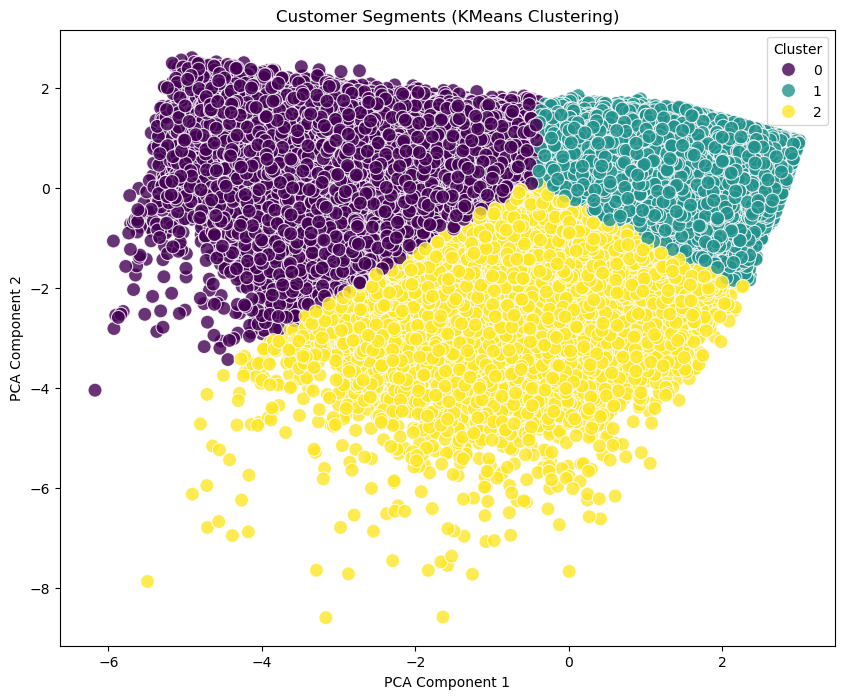

In [36]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=customer_features_pca_manual[:, 0], y=customer_features_pca_manual[:, 1], hue=clusters_pca_manual, palette='viridis', s=100, alpha=0.8)
plt.title('Customer Segments (KMeans Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()